In [ ]:
from truncatedLaplace import TruncatedLaplace
from truncatedGaussian import TruncatedGaussian
from histogramEstimator import HistogramEstimator
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
a, b = 0, 1

In [50]:
laplace = TruncatedLaplace(a=a, b=b, scale=1)
e = HistogramEstimator(
    mechanism=laplace,
    a=a,
    b=b,
    C=1.58,
    D=3.16,
    epsilon=1,
    delta=0.95,
    gamma=0.1,
)

TruncatedLaplace with C = 1.58, D = 3.16, delta = 0.95, gamma = 0.1:
m = 1355, n = 9,632,745,530, k = 452
Number of samples for one pair: 1.93e+10
Number of samples for global estimation: 9.82e+14



In [55]:
gaussian = TruncatedGaussian(a=a, b=b, scale=0.6)
e = HistogramEstimator(
    mechanism=gaussian,
    a=a,
    b=b,
    C=1.49,
    D=1.62,
    epsilon=1.39,
    delta=0.95,
    gamma=0.1,
)

TruncatedGaussian with C = 1.49, D = 1.62, delta = 0.95, gamma = 0.1:
m = 1052, n = 6,158,935,367, k = 191
Number of samples for one pair: 1.23e+10
Number of samples for global estimation: 1.12e+14



In [56]:
df = []
n_th = e.n
n = 1
while True:
    e.n = n
    valid = 0
    for i in (pbar := tqdm(range(1, 101))):
        estimate = e.estimate(0, 1)
        df.append([n, estimate])
        pbar.set_description(f"valid_ratio = {valid / i:.2g}, n = {n}, estimate = {estimate}")
        if abs(estimate - e.epsilon) < e.gamma:
            valid += 1
    if valid / 100 >= e.delta:
        break
    n *= 2

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
df = pd.DataFrame(df, columns=["n", "epsilon"])

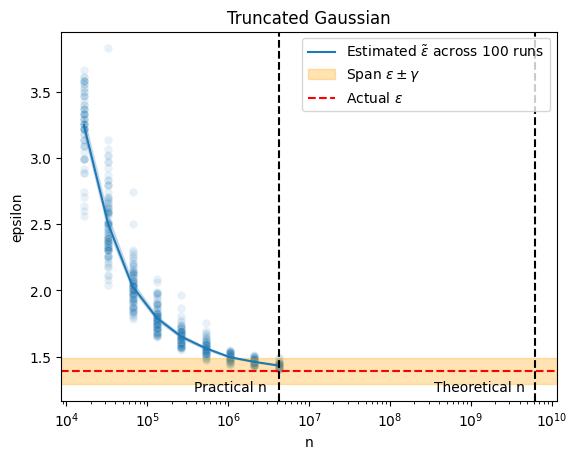

In [58]:
sns.lineplot(data=df, x="n", y="epsilon", label=r"Estimated $\tilde\epsilon$ across 100 runs")
sns.scatterplot(data=df, x="n", y="epsilon", alpha=0.1)
plt.axhspan(
    e.epsilon - e.gamma,
    e.epsilon + e.gamma,
    color="orange",
    alpha=0.3,
    label=r"Span $\epsilon \pm \gamma$",
)
plt.axhline(y=e.epsilon, color="red", linestyle="--", label=r"Actual $\epsilon$")
plt.axvline(x=e.n, color="k", linestyle="--")
plt.annotate(
    "Practical n",
    xy=(e.n, plt.ylim()[0]),
    xytext=(-35, 15),
    textcoords="offset points",
    ha="center",
    va="top",
)
plt.axvline(x=n_th, color="k", linestyle="--")
plt.annotate(
    "Theoretical n",
    xy=(n_th, plt.ylim()[0]),
    xytext=(-40, 15),
    textcoords="offset points",
    ha="center",
    va="top",
)
plt.xscale("log")
plt.title("Truncated " + e.mechanism.__class__.__name__.replace("Truncated", ""))
plt.legend()